<a href="https://colab.research.google.com/github/guilhermegranchopro/Prometheus-Alpaca/blob/Guilherme/Alpaca/Alpaca6_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Requeriments**

Connecta com a tua google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalar os requeriemntos do Alpaca API

In [2]:
pip install alpaca-trade-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.1 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=a202352598beb6ca53ecced9f6da1662f55652ed98324ede2bd8083642cb24e1
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.0
    Uninstalling msgpack-1.1.0:
      Successfully uninstalled msgpack-1.1.0
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling

Instalas a biblioteca necessária para calculares o garu necessário de semelhança entre strings

In [3]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.3 MB/s eta 0:00:00


Instalas a biblioteca necessária para calculares o garu necessário de semelhança entre strings

In [4]:
pip install fuzzywuzzy

In [40]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import alpaca_trade_api as tradeapi
import time
import os
from fuzzywuzzy import process
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt

# **Settings**

Tipos de fornecedores de dados ou IEX ou SIP.

In [6]:
# data_source = 'sip' or 'iex'
data_source = 'sip'

Todas as variaveis que se podem perdsonalizar no algoritmo.

As primeiras possibilidades de cada variável são aquelas as quais inicialmnete pensas-te que faziam mais sentido:

* symbol = 'AAPL', (retira do ficheito execel, tens o código que extrai)
* max_period = True, (podes ter erros por excesso de pedidos do API)
* start_date = '', '2022-10-31', (1 ano funciona bem para test runs)
* end_date = '', '2023-10-31', (1 ano funciona bem para test runs)
* timeframe = '1Min', '5Min', (mais de 5Min parece perder sentido a teoria)
* fisrt_marker = 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'vwap', 'average_oc', 'average_hl', (a ideia inicial é ver o volume relativo, mas pode ser interessante estudar o trade_count)
* second_marker = 'vwap', 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'average_oc', 'average_hl', (a ideia inicial era ver a média entre o high e o low - 'average_hl', mas fica na duvida ver a média entre o open e o close - 'average_oc', pode também ser muito interessante investigar o vwap)
* third_marker = '', 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'vwap', 'average_oc', 'average_hl', (não pensas te em usar uma terceira coluna para criar as matrizes, mas se os resultados impiricos assim o provarem usa)
* n_rows = 12, 10, 15, 30, 5, (pensa no timeframe quando fazes isso, o 12 pareceu ser o melhor em testes impiricos)
* sort = True, (tens de pensar na sequencia temporal se faz sentido manter ou não)
* relative_first_marker = True, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos, o volume pensas te inicialmnete deixar em impirico para o tensor para normalizares os tensores)
* relative_second_marker = False, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos)
* relative_third_marker = False, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos)
* decimals = '', 3, 4 (tens de ver o que os dados impiricos te dizem se com arrendondamentos facilitas ou n a vida do AI)
* LSTM_boolean = True, (em caso de falso não usas um LSTM e partes do precipio que a relação causal deixa de ser importante para a cosntrução do tensor, quando normalizas os dados a esperança seria de não teres de usar um LSTM)
* epochs = 5, (este numero tende a ser irrelevante porque tens um checkpoint de callback referente ao melhor resultado de validation accuracy)
* early_stopping = True, (podes ligar ou desligar de forma automática o early_stopping, ou seja, o call back aqui)
* call_back = 'val_accuracy', 'val_loss', 'accuracy', 'loss' (escolhes o paramtero que monitora o call back)
* patience = 2, 50, 100, 500, 1000 (escolhes a paciencia do call back)
* batch_size = 64, 16, 32, 128, 256, 512 (varias com o tramanho do dataset, mas pensa que tens conseguido datasets bem grandes portanto usa os maiores valores)

In [7]:
symbol = 'AAPL'
max_period = True
start_date = '2016-10-31'
end_date = '2023-12-31'
timeframe = '5Min'
fisrt_marker = 'volume'
second_marker = 'vwap'
third_marker = ''
n_rows = 12
sort = True
relative_first_marker = True
relative_second_marker = False
relative_third_marker = False
decimals = ''
LSTM_boolean = True
epochs = 5
early_stopping = True
call_back = 'val_accuracy'
patience = 2
batch_size = 64

# **Algorithm**

Uso o Yahoo Finance API para saber quando é que a empresa que estou a usar entrou no mercado, quando a empresa IPO.

In [8]:
def get_start_date():
    #Data de inicio dos dados historicos do Alpaca
    return "2016-01-01"

Saber o dia que é hoje, o dia que o código está a correr, o modelo está a ser criado

In [9]:
def get_end_date(symbol):
    # Obter a data e hora atuais
    current_date_time = datetime.now()
    # Make start timezone aware
    current_date_time = current_date_time.replace(tzinfo=timezone.utc)
    return current_date_time

Usas a tua senha da tua conta no ALpca API para usares a API, tens de te conectar á tua conta.

In [10]:
def alpaca_autentification():
    # Exemplo de caminho no Google Drive (ajuste conforme a sua organização):
    # /content/drive/MyDrive/pasta/API_Keys.txt
    caminho_arquivo = '/content/drive/MyDrive/AI Financial Analisys/Summer Project/Test/API_Keys.txt'

    # Lê as linhas do arquivo
    with open(caminho_arquivo, 'r') as f:
        lines = f.readlines()

    # Extrai cada valor (removendo possíveis quebras de linha com .strip())
    API_KEY = lines[0].strip()
    SECRET_KEY = lines[1].strip()
    BASE_URL = lines[2].strip()

    # Inicializa a API Alpaca com as credenciais lidas do arquivo
    api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

    return api

Depois chamas a API para retirar os dados que necessitas. Para a API não te bloquear usas um intervalo de 1 segundo sempre que chamas a API para conseguires atingir elevada granuralidade dos dados, sem seres bloqueado pela API.

In [11]:
# Function to fetch data in chunks to avoid rate limits
def fetch_data(symbol, start, end, timeframe, api, data_source='sip'):
    all_data = []
    current_start = start

    while current_start < end:
        current_end = current_start + timedelta(days=7)
        if current_end > end:
            current_end = end

        # Fetch the historical data
        bars = api.get_bars(
            symbol,
            timeframe,
            start=current_start.strftime('%Y-%m-%d'),
            end=current_end.strftime('%Y-%m-%d'),
            feed=data_source
        ).df

        all_data.append(bars)
        current_start = current_end
        time.sleep(1)  # Adjust sleep interval based on rate limits

    return pd.concat(all_data)

função para criar o nome do ficheiro. O nome do ficheiro encriptará todas varaiveis/hyperparametros necessários para voltar a correr o ficheiro do modelo ou o csv com todos os dados. (tens um dicionário do que cada uma dos paramteros representa mais a baixo)

In [12]:
def create_file_name(symbol, max_period, start_date, end_date,
                     timeframe, fisrt_marker, second_marker, third_marker,
                     n_rows, sort, relative_first_marker, relative_second_marker,
                     relative_third_marker, decimals, LSTM_boolean, epochs,
                     early_stopping, call_back, patience, batch_size,
                     test_loss, test_accuracy, model_file):

    # Nome aproximado do arquivo
    if model_file == True:
        nome_aproximado = 's=' + symbol + '+' + 'mp=' + str(max_period) + '+' + 'sd=' + \
        start_date + '+' + 'ed=' + end_date + '+' + 'tf=' + timeframe + '+' + \
        'fm=' + fisrt_marker + '+' + 'sm=' + second_marker + '+' + \
        'tm=' + third_marker + '+' + 'r=' + str(n_rows) + '+' + \
        'sort=' + str(sort) + '+' + 'rfm=' + str(relative_first_marker) + '+' + \
        'rsm=' + str(relative_second_marker) + '+' + \
        'rtm=' + str(relative_third_marker) + '+' + \
        'd=' + decimals + '+' + 'Lb=' + str(LSTM_boolean) + '+' + 'e=' + str(epochs) + '+' + \
        'es=' + str(early_stopping) + '+' + 'cb=' + call_back + '+' + \
        'p=' + str(patience) + '+' + 'bs=' + str(batch_size) + '+' + \
        'tl=' + str(test_loss) + '+' + 'ta=' + str(test_accuracy) + '.keras'
    else:
        nome_aproximado = 's=' + symbol + '+' + 'mp=' + str(max_period) + '+' + 'sd=' + \
        start_date + '+' + 'ed=' + end_date + '+' + 'tf=' + timeframe + '.csv'

    return nome_aproximado

função para procurar se o modelo e os dados são originais, caso não sejamm originais é porque foi encontrado dados e pelo menos um modelo identicos ao que está a ser pedido ao algoritmo já guradado na base de dados e caso isso aconteça, os dados não seram novamente retirados da API mas sim seram usados aqueles que já se encontram na base de dados (arquivos da tua google drive). Isto é feito por compração de nomes de ficheiros, já que no nome dos ficheiros encotra-se encriptado tudo o que é necessário para voltar a correr o algoritmo em termos de hyperparamtros e variaveis.

In [13]:
def old_dataset_function(symbol, max_period, start_date, end_date,
                timeframe, fisrt_marker, second_marker, third_marker,
                n_rows, sort, relative_first_marker, relative_second_marker,
                relative_third_marker, decimals, LSTM_boolean, epochs,
                early_stopping, call_back, patience, batch_size,
                test_loss, test_accuracy, model_file):

    # Defina o caminho do diretório no Google Drive
    diretorio = '/content/drive/MyDrive/AI Financial Analisys/Summer Project/Dataset/Raw Data'

    # Nome aproximado do arquivo
    nome_aproximado = create_file_name(symbol, max_period, start_date, end_date,
                                      timeframe, fisrt_marker, second_marker, third_marker,
                                      n_rows, sort, relative_first_marker, relative_second_marker,
                                      relative_third_marker, decimals, LSTM_boolean, epochs,
                                      early_stopping, call_back, patience, batch_size,
                                      test_loss, test_accuracy, model_file)

    # Lista todos os arquivos no diretório
    arquivos = os.listdir(diretorio)

    # Encontra o arquivo mais próximo
    if process.extractOne(nome_aproximado, arquivos):
        arquivo_mais_proximo, pontuacao = process.extractOne(nome_aproximado, arquivos)
    else:
        arquivo_mais_proximo = None
        pontuacao = None

    if arquivo_mais_proximo and pontuacao==100:
        caminho_do_modelo = os.path.join(diretorio, arquivo_mais_proximo)
        print("Nome do arquivo mais próximo:")
        print(arquivo_mais_proximo)
        print()
        print("Caminho completo do modelo:")
        print(caminho_do_modelo)
        print()
        print("Pontuação de similaridade:")
        print(pontuacao)
        old_dataset = True
    else:
        print("Nenhum arquivo próximo encontrado.")
        caminho_do_modelo = ''
        old_dataset = False

    return old_dataset, caminho_do_modelo

Usando a alpaca API para sacar os dados agora que já deste login á tua conta da alpaca com a tua senha pessoal anteriormente.

In [14]:
def get_all_data(symbol = 'AAPL', max_period = True, start_date = '', end_date= '', timeframe = '1Min', data_source = 'sip'):
    api = alpaca_autentification()

    if max_period and start_date == '' and end_date == '':
        start_date = get_start_date(symbol)
        end_date = get_end_date(symbol)
    elif start_date != '' and end_date != '':
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    else:
        start_date = datetime(2022, 12, 31)
        end_date = datetime(2023, 12, 31)

    # Fetch the historical data
    apple_data = fetch_data(symbol, start_date, end_date, timeframe, api, data_source)
    return apple_data

Esta função irá preparar dos dados para o modelo. Do Alpca seram retirados multiplos parametros do mercado interessa-te selecionar apenas os que queres alimentar ao modelo para isso esat função é usada para os selecionar. podes escolher entre 'close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap', que são os parametros de mercado dados por default pelo Alpaca. Mas para além disso crias te outras 2 métricas com base nas métricas já dadas caso as queiras testar eslas são: 'average_oc' e 'average_hl', que correspondem, respetivamente, ao ponto médio entre o open e o close e o ponto médio entre o high e o low.



*   close é o preço de fecho da ação naquele intervalo temporal
*   high é o preço mais alto da ação naquele intervalo temporal
*   low é o preço mais baixo da ação naquele intervalo temporal
*   trade_count é o número de matches entre compradosres e vendedores naquele intervalo temporal
*   open é o preço de abertura da ação naquele intervalo temporal
*   vwap é o preço da ação por volume naquele intervalo temporal ( uma forma diferente de olhar para o valor intrinseco de uma ação)



In [15]:
# Function to prepare the data
def prepare_data(data, fisrt_marker, second_marker, third_marker):
    # Selecionar colunas relevantes e fazer uma cópia para evitar advertências
    data_selected = data[['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap']].copy()

    # Calcular a média entre 'Open' e 'Close' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_oc'] = data_selected[['open', 'close']].mean(axis=1)

    # Calcular a média entre 'High' e 'Low' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_hl'] = data_selected[['high', 'low']].mean(axis=1)

    # Selecionar as colunas finais
    if third_marker != '':
        data_final = data_selected[[fisrt_marker, second_marker, third_marker]]
    else:
        data_final = data_selected[[fisrt_marker, second_marker]]

    return data_final

Agora temos de continuara a preparação dos dados para serem alimentado ao modelo para isso crio matrizes para segmentar os dados, cada matriz vai ter uma label: 0 ou 1. Assim o dataset vai ser constituido por ,atrizes de tamanho a defenir pelo o usuário do algoritmo e pelas suas respetivas labels de 0 ou 1. As matrizes no máximo poderão ter até 3 colunas, cada coluna representa uma metrica difrente do mercado. As linhas estam inicialmente organizadas de forma sequencial e representação a cada uma a granuralidade mínima do dataset, assim se a granuralidade é de 1 minuto e uma matriz tem 5 linhas, cada matriz representa 5 minutos continuos de métricas do mercado no tempo. As métricas de cada matriz por coluna podem ser formatadas como relativas, o que significa que as métricas da matriz seram apresentadas de forma relativa á matriz em questão, o que pode ser interessante para modelos sem ser um LSTM, pois permite que os dados históricos sejam baralhados temporalmente e manetenham coerência. Como é o caso por exemplo do preço e do volume, com a inflação é normal que o preço aumente mas não queremos que isso cause uma precepção errada de magnitude superior ao nosso modelo assim o 'relative' faz com que as métricas das matrizes apareçam como valores ponderados aos restantes valores da matriz, assim cada valor da métrica relativa é dividida pelo somatório dos valores dessa métrica presentes na matriz.

In [16]:
# Função para criar as matrizes e os labels
def create_matrices(data_final, n = 12, fisrt_marker = 'volume', second_marker = 'vwap', third_marker = '', relative_fisrt_marker = True, relative_second_marker = False, relative_third_marker = False):
    num_rows = data_final.shape[0]
    num_matrices = num_rows // n  # Número de matrizes completas que podemos formar

    matrices = []
    matrices_y = []

    for i in range(num_matrices):
        start_idx = i * n
        end_idx = start_idx + n
        matrix = data_final.iloc[start_idx:end_idx].copy()

        if relative_fisrt_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[fisrt_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[fisrt_marker] = matrix[fisrt_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        if relative_second_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[second_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[second_marker] = matrix[second_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        if relative_third_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[third_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[third_marker] = matrix[third_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        # Criar labels
        if i > 0:  # Ignorar a primeira matriz para alinhamento correto
            first_value = matrices[i][0, 1]
            last_value = matrices[i][n-1, 1]
            delta = last_value - first_value
            delta_bi = 1 if delta >= 0 else 0
            matrices_y.append(delta_bi)

    return matrices, matrices_y

Caso se entenda que a ordem temporal, devido á elevada granuraridade dos dados de uma matriz, é irrelevante, esta função permite ordenar por ordem decrescente da métrica da segunda coluna os valores de uma matriz e assim por exemplo caso na segunda coluna se tenha o valor de volume estaria se a observar em cada matriz o preço por ordem crescente do volume. Esta função pode ser ativada ou desativada e pode ser interessante para uma elevada granuralidade em que as matrizes apenas representam 5 minutos e não se está a usar uma LSTM.

In [17]:
def sort_matrices(matrices):
    # Ordenar as linhas de cada matriz por ordem decrescente da coluna Average (segunda coluna)
    matrices_x = []
    for matrix in matrices:
        sorted_indices = np.argsort(matrix[:, 1])[::-1]
        sorted_matrix = matrix[sorted_indices]
        matrices_x.append(sorted_matrix)
    return matrices_x

Funçaõ para passar as matrizes para tensores para poderem ser tartadas pelo TensorFlow

In [18]:
def tensor_creator(matrices_x, matrices_y):
    # Converter listas para arrays numpy
    matrices_x = np.array(matrices_x)
    matrices_y = np.array(matrices_y)
    return matrices_x, matrices_y

Função que integra todas as outras funções que falamos para obter o dataset e manipulá-lo conforme o utilizador do algoritmo deseja

In [19]:
def get_dataset(company_data, n_rows, sort = True, fisrt_marker = 'volume', second_marker = 'vwap' ,
                third_marker = '', relative_fisrt_marker = True, relative_second_marker = False,
                relative_third_marker = False, decimals = ''):
    matrices_x = []
    matrices_y = []

    matrices_x, matrices_y = create_matrices(company_data, n_rows, fisrt_marker, second_marker, third_marker, relative_fisrt_marker, relative_second_marker, relative_third_marker)

    if sort:
        matrices_x = sort_matrices(matrices_x)

    # Remover a última matriz de matrices_x para alinhamento com matrices_y
    if matrices_x:
        matrices_x.pop()

    matrices_x, matrices_y = tensor_creator(matrices_x, matrices_y)

    if decimals != '':
        matrices_x = np.round(matrices_x, decimals = decimals)
    return matrices_x, matrices_y

Esta função divide o dataset em treino, validação e teste. Esta divisão tem de ser feita de forma diferente caso se esteja a usar um LSTM ou não. Se for usado um LSTM para manter a ordem temporal dos dados o datset é dividido em fatias sequêncis primeiros 60% dos dados históricos para treino, proximos 20% para validação e ultimos 20% para teste. Se não for usado uma LSTM os dados históricos são formatados em matrizes, as matrizes são baralhadas e entregues baralhadas tempralmente ao modelo.

In [20]:
def split_dataset(matrices_x, matrices_y, LSTM = True):

    if LSTM:
        # Total de amostras
        n_samples = matrices_x.shape[0]

        # Índices para divisão
        train_size = int(0.6 * n_samples)  # 60% para treino
        val_size = int(0.2 * n_samples)    # 20% para validação
        test_size = n_samples - train_size - val_size  # 20% para teste

        # Dividir os dados sequencialmente
        X_train = matrices_x[:train_size]
        y_train = matrices_y[:train_size]

        X_val = matrices_x[train_size:train_size + val_size]
        y_val = matrices_y[train_size:train_size + val_size]

        X_test = matrices_x[train_size + val_size:]
        y_test = matrices_y[train_size + val_size:]
    else:
        # Dividir os dados em conjuntos de treinamento + validação e teste
        X_train_val, X_test, y_train_val, y_test = train_test_split(matrices_x, matrices_y, test_size=0.2, random_state=42)

        # Dividir o conjunto de treinamento + validação em treinamento e validação
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    return X_train, X_val, X_test, y_train, y_val, y_test


Função para criar o modelo de AI. Esta função permite escolher entre duas arquiteturas diferentes. É possível escolher entre usar uma LSTM, caso se queira dar prioridade á lógica temporal do mercado, ou usar uma arquitetura diferente caso não se queira dar essa relevância à ordem temporal.

Pode ser interessante não usar uma LSTM. O padrão de procedimento na industria é usar um LSTM devido ao motivo lógico que esxite uma padrão temporal de acontecimentos obvios no mercado. No entanto, para explorar outras prespetivas de olhar para o mercado, desenvolves te várias ferramentas que em teoria permitiriam olhar para o mercado sem ser relevante a ordem temporal. A ideia é que pela teoria do mercado eficiente combiando com a tua ideia de um torque financeiro, que deve abrir um curto intervalo de tempo no mercado para ganhar lucro comprativamento com os outros players do mercado. Assim se aumentares por muito a granuralidade e assim estarás a fazer previsões para a matriz seguinte, ou seja, se as matrizes apenas representam 5 minutos no mercado, logo somando essa a ideia de uma granuralidade elevada com o facto de tornar os parametros na matriz relativos, e ordenar as linhas da matriz por ordem crecente dos valores e não tempora, todas estas ferramentas juntas em teoria permitiriam analisar o mercado sem ter em conta a ordem temporal.


In [21]:
# Função para construir a rede neural
def build_model(input_shape, LSTM_boolean=True):
    warnings.filterwarnings('ignore', category=UserWarning, module='keras')
    model = Sequential()

    if LSTM_boolean:
        model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
    else:
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    # Compilando o modelo com uma taxa de aprendizado ajustada
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

Função para treinar o modelo, usamos earlystopping para saber qunado para de forma mais correta as épocas. Esta função também grava o histórico de treinamento assim como também testa o modelo contra o dataset de teste e grava os resultados.

In [34]:
def model_training(model, X_train, X_val, X_test, y_train, y_val, y_test, epochs=5, early_stopping = True, call_back = 'val_accuracy', patience = 2, batch_size=32):

    if early_stopping:
        early_stopping = EarlyStopping(monitor=call_back, patience=patience, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
    else:
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val))

    return model, history

In [67]:
def run_model_on_test(model, X_test, y_test):
    # Avaliar o modelo nos dados de teste
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    return test_loss, test_accuracy

In [65]:
def create_confusion_matrix(model, X_test, y_test):

    y_pred = model.predict(X_test)

    # Função auxiliar para converter saídas para rótulos
    def convert_to_labels(y):
        if y.ndim > 1 and y.shape[1] > 1:
            return np.argmax(y, axis=1)
        elif np.issubdtype(y.dtype, np.floating):
            return (y > 0.5).astype("int32").flatten()
        else:
            return y.flatten() if y.ndim > 1 else y

    y_pred_labels = convert_to_labels(y_pred)
    y_test_labels = convert_to_labels(y_test)

    cm = sk_confusion_matrix(y_test_labels, y_pred_labels)
    cm_percentage = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title("Confusion Matrix (%)")

    fig = disp.figure_
    return cm, cm_percentage, fig

função que permite dar plot dos resultados da historia de treinamento e dar plot aos resultado do modelo no dataset de teste.

In [25]:
def plot_accuracy(history):

    fig, ax = plt.subplots()
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title('Model Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    return fig

In [26]:
def plot_loss(history):

    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    return fig

# **Results**

Função que agrega todas as anteriores para preceber se com base nas variaveis introduzidas no algoritmo, o algoritmo já foi corrido alguma vez com estes settings ou não. Caso tenha sido ele vai buscar á google drive os dados guardados anteriormente com estes settings o que otimiza o tempo que demora a correr o algoritmo, pois caso contrário é necessário usar a API Alpaca para obter todos os dados o que pode demorar bastante tempo.

In [27]:
old_dataset, caminho_do_modelo = old_dataset_function(symbol, max_period, start_date, end_date,
                                  timeframe, fisrt_marker, second_marker, third_marker,
                                  n_rows, sort, relative_first_marker, relative_second_marker,
                                  relative_third_marker, decimals, LSTM_boolean, epochs,
                                  early_stopping, call_back, patience, batch_size, 0, 0, False)

if old_dataset:
    company_data = pd.read_csv(caminho_do_modelo, index_col=0)
else:
    company_data = get_all_data(symbol, max_period, start_date, end_date, timeframe, data_source)

company_data

Nome do arquivo mais próximo:
s=AAPL+mp=True+sd=2016-10-31+ed=2023-12-31+tf=5Min.csv

Caminho completo do modelo:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Dataset/Raw Data/s=AAPL+mp=True+sd=2016-10-31+ed=2023-12-31+tf=5Min.csv

Pontuação de similaridade:
100


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-10-31 08:00:00+00:00,113.9000,113.90,113.7500,6,113.8900,500,113.845860
2016-10-31 08:05:00+00:00,113.4000,113.76,113.4000,3,113.7600,823,113.650304
2016-10-31 09:00:00+00:00,113.7600,113.76,113.7600,2,113.7600,144,113.780833
2016-10-31 09:20:00+00:00,113.9500,113.95,113.8800,2,113.8800,275,113.905455
2016-10-31 10:05:00+00:00,113.7500,113.75,113.7500,1,113.7500,245,113.750000
...,...,...,...,...,...,...,...
2023-12-30 00:35:00+00:00,192.1200,192.14,192.1100,44,192.1400,1639,192.130354
2023-12-30 00:40:00+00:00,192.1500,192.15,192.1118,41,192.1118,2863,192.135717
2023-12-30 00:45:00+00:00,192.2000,192.22,192.1500,37,192.1500,3105,192.204240


Esta função é chamada para fazer o tratamento dos dados brutos conforme as settings que o usuário decidiu antes dos dados serem alimentados ao modelo.

In [28]:
company_data_prepared = prepare_data(company_data, fisrt_marker, second_marker, third_marker)

company_data_prepared

,volume,vwap
timestamp,,
2016-10-31 08:00:00+00:00,500,113.845860
2016-10-31 08:05:00+00:00,823,113.650304
2016-10-31 09:00:00+00:00,144,113.780833
2016-10-31 09:20:00+00:00,275,113.905455
2016-10-31 10:05:00+00:00,245,113.750000
...,...,...
2023-12-30 00:35:00+00:00,1639,192.130354
2023-12-30 00:40:00+00:00,2863,192.135717
2023-12-30 00:45:00+00:00,3105,192.204240


esta função separa os dadaos em matrizes com as dimensões esplicitas nas settings do algoritmo.

In [29]:
matrices_x, matrices_y = get_dataset(company_data_prepared, n_rows, sort, fisrt_marker, second_marker , third_marker, relative_first_marker, relative_second_marker, relative_third_marker, decimals)

print(matrices_x)
print(matrices_x.shape)
print(matrices_y)
print(matrices_y.shape)
print()

[[[2.55980639e-02 1.13905455e+02]
  [1.11700642e-01 1.13870000e+02]
  [4.65419343e-02 1.13845860e+02]
  ...
  [1.21009029e-01 1.13738462e+02]
  [1.86167737e-02 1.13720000e+02]
  [7.66080238e-02 1.13650304e+02]]

 [[8.74403410e-02 1.13793012e+02]
  [2.04180598e-02 1.13757500e+02]
  [3.90571961e-01 1.13734021e+02]
  ...
  [1.65896736e-02 1.13644323e+02]
  [1.56963835e-01 1.13638618e+02]
  [1.65896736e-01 1.13628711e+02]]

 [[2.32956492e-03 1.13786212e+02]
  [6.06592053e-04 1.13780000e+02]
  [4.24614437e-04 1.13772694e+02]
  ...
  [3.23410996e-03 1.13578300e+02]
  [5.31160917e-04 1.13558154e+02]
  [2.23570344e-01 1.13368599e+02]]

 ...

 [[3.77526740e-02 1.92689513e+02]
  [1.74833685e-02 1.92675211e+02]
  [1.08355699e-01 1.92668680e+02]
  ...
  [2.69245237e-02 1.92536548e+02]
  [4.76995453e-01 1.92534327e+02]
  [2.32410485e-02 1.92532662e+02]]

 [[5.30569708e-02 1.92568595e+02]
  [1.15840667e-02 1.92545147e+02]
  [1.24735989e-01 1.92506790e+02]
  ...
  [1.12623900e-01 1.92384073e+02]
  [4

Esta função divide o dataset em treino, teste e validação

In [30]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(matrices_x, matrices_y, LSTM_boolean)

# Exibir as formas dos arrays resultantes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print()

Shape of X_train: (18453, 12, 2)
Shape of y_train: (18453,)
Shape of X_val: (6151, 12, 2)
Shape of y_val: (6151,)
Shape of X_test: (6151, 12, 2)
Shape of y_test: (6151,)



Este parte do código permite obter as características da arqitetura do AI que está a ser usada.

In [31]:
if third_marker == '':
  input_shape = (n_rows, 2)
else:
  input_shape = (n_rows, 3)
model = build_model(input_shape, LSTM_boolean)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

Esta função treina o modelo nos dados de treino e validação. E testa o modelo contra os dados de teste.

In [35]:
model, history = model_training(model, X_train, X_val, X_test, y_train, y_val, y_test, epochs, early_stopping, call_back, patience, batch_size)

Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5268 - loss: 0.6920 - val_accuracy: 0.5202 - val_loss: 0.6928
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5260 - loss: 0.6919 - val_accuracy: 0.5202 - val_loss: 0.6924
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5263 - loss: 0.6918 - val_accuracy: 0.5202 - val_loss: 0.6927


In [68]:
# Executa o modelo nos dados de teste e obtém as predições e rótulos
test_loss, test_accuracy = run_model_on_test(model, X_test, y_test)

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5151 - loss: 0.6935


193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


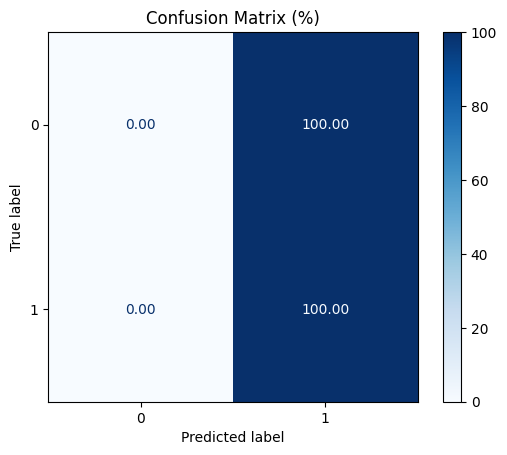

In [70]:
# Cria a matriz de confusão e obtém a figura
cm, cm_percentage, fig_confusion_matrix = create_confusion_matrix(model, X_test, y_test)

Plota os resultados durante a fase de treinamento e durante a fase de teste.

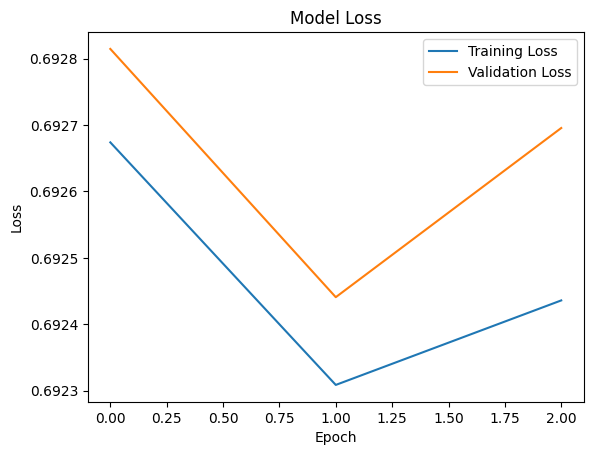

In [71]:
fig_loss = plot_loss(history)

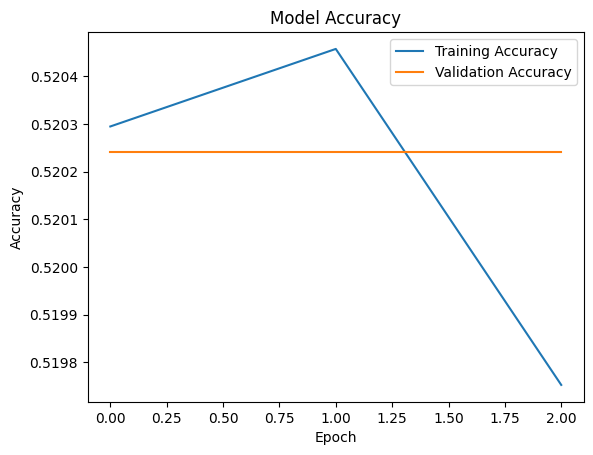

In [72]:
fig_accuracy = plot_accuracy(history)

# **Save History & Images**

# **Save Model & Data**

Caso o modelo seja corrido em settings originais ou caso o modelo apresente resultados inovadores o modelo será gravado usando esta função e os settings que influenciram o modelo e os resultados obtidos pelo modelo são encriptados no nome do ficheiro no qual o modelo fica guardado.

In [ ]:
# Defina o caminho do diretório no Google Drive
caminho_para_salvar_modelo = '/content/drive/MyDrive/AI Financial Analisys/Summer Project/Neural Network/Models'

# Verifique se o diretório existe, caso contrário, crie-o
if not os.path.exists(caminho_para_salvar_modelo):
    print(f"O dirétório {caminho_para_salvar_modelo} não existe.")

file_name = create_file_name(symbol, max_period, start_date, end_date,
                     timeframe, fisrt_marker, second_marker, third_marker,
                     n_rows, sort, relative_first_marker, relative_second_marker,
                     relative_third_marker, decimals, LSTM_boolean, epochs,
                     early_stopping, call_back, patience, batch_size,
                     test_loss, test_accuracy, True)

caminho_completo_modelo = os.path.join(caminho_para_salvar_modelo, file_name)

# Salva o modelo em formato
model.save(caminho_completo_modelo)

print("Ficheiro do Modelo:")
print(file_name)
print()
print("Modelo salvo em:")
print(caminho_para_salvar_modelo)

Ficheiro do Modelo:
s=AAPL+mp=True+sd=2016-10-31+ed=2023-12-31+tf=5Min+fm=volume+sm=vwap+tm=+r=12+sort=True+rfm=True+rsm=False+rtm=False+d=+Lb=True+e=5+es=True+cb=val_accuracy+p=2+bs=64+tl=0.6923301815986633+ta=0.522516667842865.keras

Modelo salvo em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Neural Network/Models


Caso os dados sejam coletados por uma versão do algoritmo que correu em settings originais os dados seram gravados usando esta função e os settings que influenciram o levaram a obeter os respetivos dados/dataset modelo são encriptados no nome do ficheiro CSV no qual os dados ficam guardados.

In [ ]:
# Defina o caminho do diretório no Google Drive
caminho_para_salvar_dados = '/content/drive/MyDrive/AI Financial Analisys/Summer Project/Dataset/Raw Data'

# Verifique se o diretório existe, caso contrário, crie-o
if not os.path.exists(caminho_para_salvar_dados):
    os.makedirs(caminho_para_salvar_dados)
    print(f"Diretório {caminho_para_salvar_dados} criado com sucesso.")
else:
    print(f"O diretório {caminho_para_salvar_dados} já existe.")

print()

file_name = create_file_name(symbol, max_period, start_date, end_date,
                     timeframe, fisrt_marker, second_marker, third_marker,
                     n_rows, sort, relative_first_marker, relative_second_marker,
                     relative_third_marker, decimals, LSTM_boolean, epochs,
                     early_stopping, call_back, patience, batch_size,
                     test_loss, test_accuracy, False)

# Defina o caminho completo para salvar o arquivo
caminho_completo_dados = os.path.join(caminho_para_salvar_dados, file_name)

# Salve o dataframe no caminho especificado
company_data.to_csv(caminho_completo_dados)

print("Ficheiro dos Dados:")
print(file_name)
print()
print("Dados salvos em:")
print(caminho_para_salvar_dados)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Dataset/Raw Data já existe.

Ficheiro dos Dados:
s=AAPL+mp=True+sd=2016-10-31+ed=2023-12-31+tf=5Min.csv

Dados salvos em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Dataset/Raw Data
